## Time Series Assingment


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline

## About the data : 

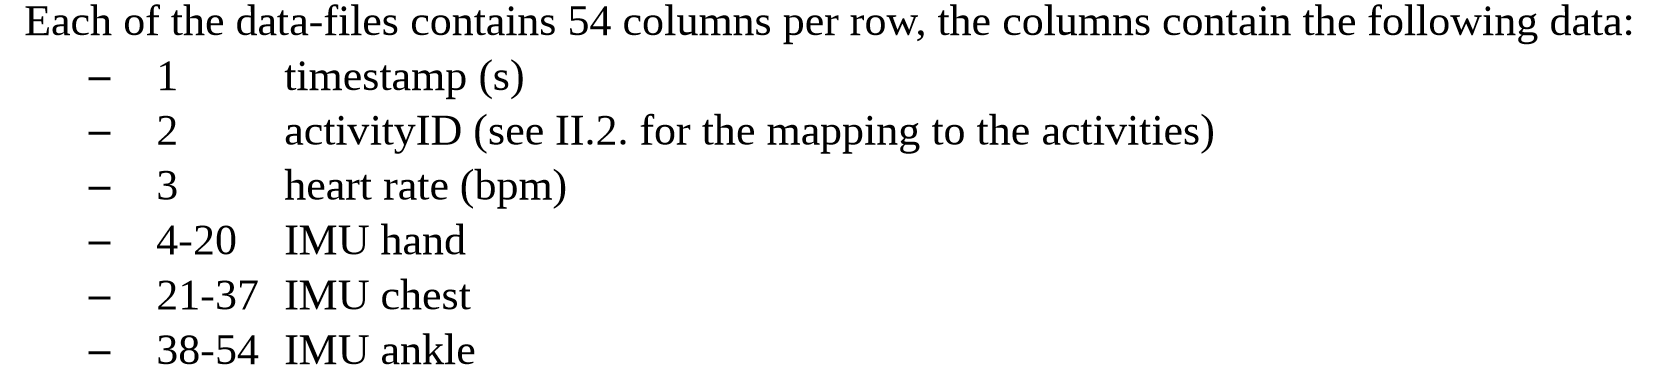

**Activities**
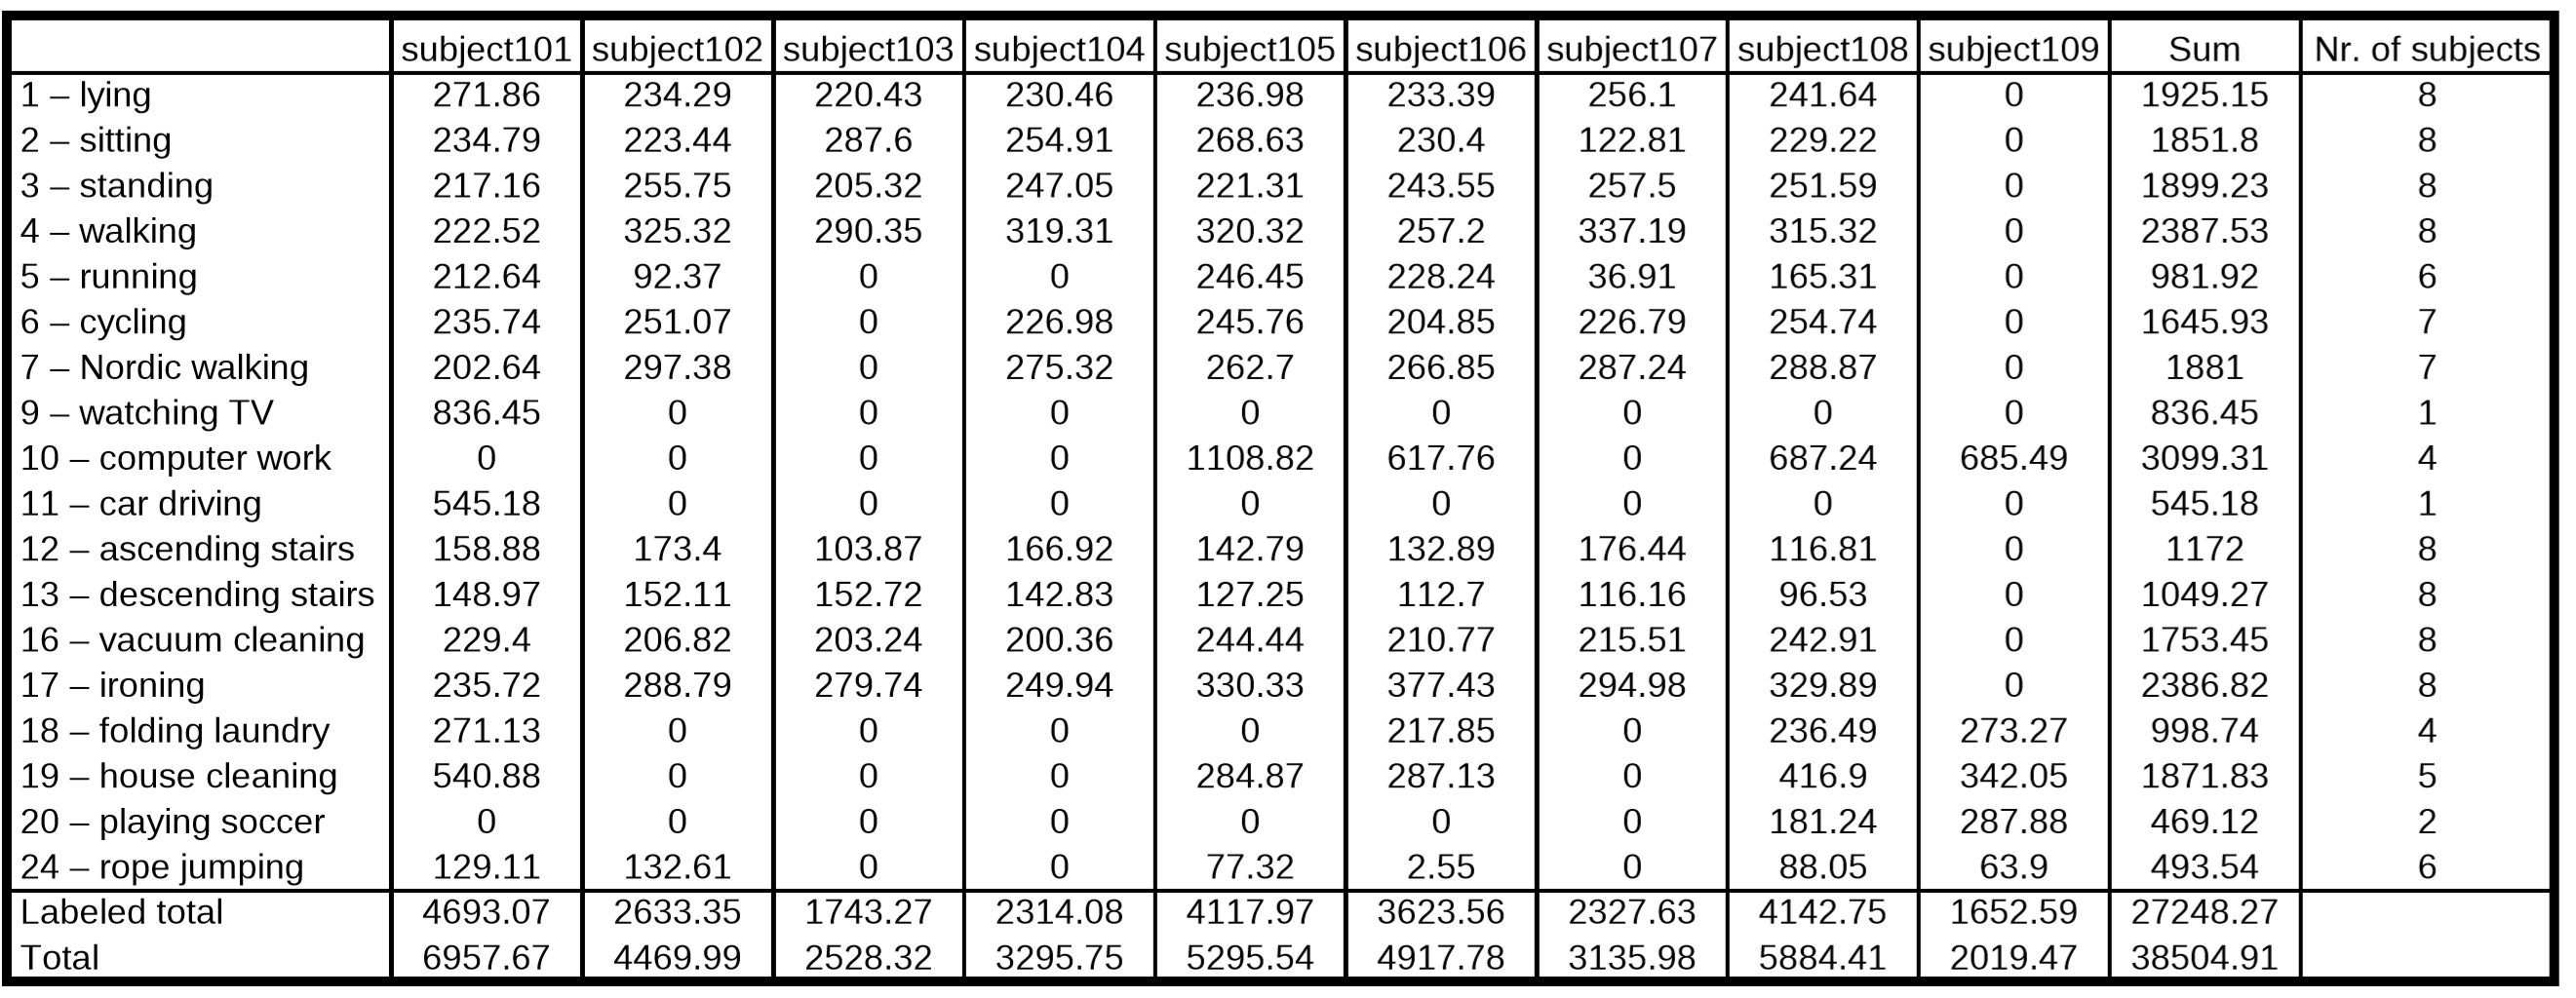

**Subjects**
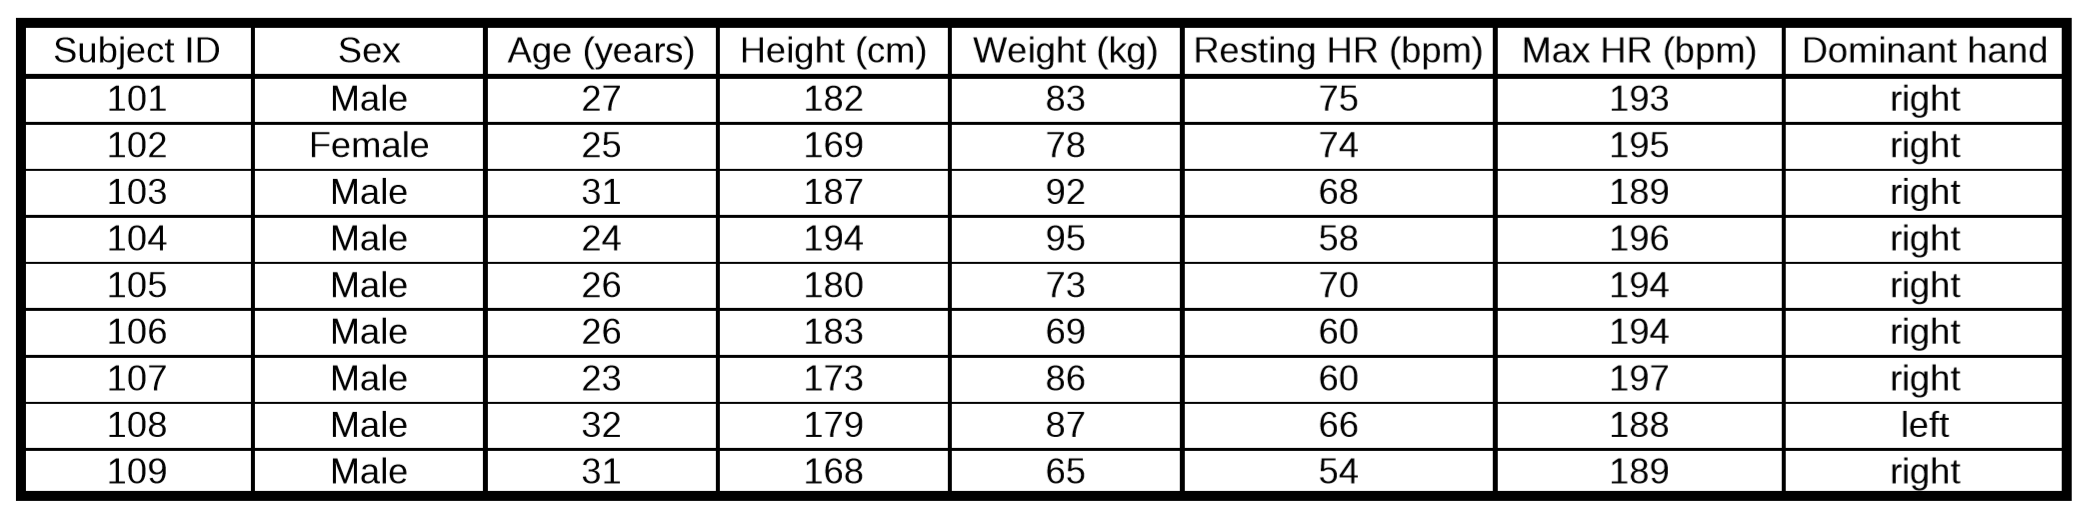

In [3]:
foler_data_path = r'drive/My Drive/DeepLearnCourse/ass2/Protocol/'

subjectID = [101,102,103,104,105,106,107,108,109]

activityIDdict = {0: 'transient',
              1: 'lying',
              2: 'sitting',
              3: 'standing',
              4: 'walking',
              5: 'running',
              6: 'cycling',
              7: 'Nordic_walking',
              9: 'watching_TV',
              10: 'computer_work',
              11: 'car driving',
              12: 'ascending_stairs',
              13: 'descending_stairs',
              16: 'vacuum_cleaning',
              17: 'ironing',
              18: 'folding_laundry',
              19: 'house_cleaning',
              20: 'playing_soccer',
              24: 'rope_jumping' }

activityNameToIdDict = {'transient' : 0,
              'lying' : 1,
              'sitting' : 2,
              'standing' :3,
              'walking' :4,
              'running' :5,
              'cycling':6,
              'Nordic_walking' :7,
              'watching_TV':9,
              'computer_work':10,
              'car driving':11,
              'ascending_stairs':12,
              'descending_stairs':13,
              'vacuum_cleaning':16,
              'ironing':17,
              'folding_laundry':18,
              'house_cleaning':19,
              'playing_soccer':20,
              'rope_jumping':24 }

activity_nums = list(activityIDdict.keys())
activity_names = list(activityIDdict.values())

cols = ["timestamp", "activityID","heartrate"]

IMUhand = ['handTemperature', 
           'handAcc16_x', 'handAcc16_y', 'handAcc16_z', 
           'handAcc6_x', 'handAcc6_y', 'handAcc6_z', 
           'handGyro_x', 'handGyro_y', 'handGyro_z', 
           'handMagne_x', 'handMagne_y', 'handMagne_z',
           'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']


IMUchest = ['chestTemperature', 
           'chestAcc16_x', 'chestAcc16_y', 'chestAcc16_z', 
           'chestAcc6_x', 'chestAcc6_y', 'chestAcc6_z', 
           'chestGyro_x', 'chestGyro_y', 'chestGyro_z', 
           'chestMagne_x', 'chestMagne_y', 'chestMagne_z',
           'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']


IMUankle = ['ankleTemperature', 
           'ankleAcc16_x', 'ankleAcc16_y', 'ankleAcc16_z', 
           'ankleAcc6_x', 'ankleAcc6_y', 'ankleAcc6_z', 
           'ankleGyro_x', 'ankleGyro_y', 'ankleGyro_z', 
           'ankleMagne_x', 'ankleMagne_y', 'ankleMagne_z',
           'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

columns = cols + IMUhand + IMUchest + IMUankle 
columns_with_subject = cols + IMUhand + IMUchest + IMUankle + ['subject_num']

len(columns) # need to be 54



54

we need to read all train data into one dataframe to work with
we will read each subject table and concatenate them to eachother

# Q1 - Data Exploration:

In [4]:
all_data = pd.DataFrame()
for i in range (1, 10):
    procData = pd.read_table(foler_data_path + 'subject10{}.dat'.format(i), header=None, sep='\s+')
    procData.columns = columns
    procData['subject_id'] = 100 + i
    all_data = all_data.append(procData, ignore_index=True)

all_data.reset_index(drop=True, inplace=True)
all_data.head()


,timestamp,activityID,heartrate,handTemperature,handAcc16_x,handAcc16_y,handAcc16_z,handAcc6_x,handAcc6_y,handAcc6_z,handGyro_x,handGyro_y,handGyro_z,handMagne_x,handMagne_y,handMagne_z,handOrientation1,handOrientation2,handOrientation3,handOrientation4,chestTemperature,chestAcc16_x,chestAcc16_y,chestAcc16_z,chestAcc6_x,chestAcc6_y,chestAcc6_z,chestGyro_x,chestGyro_y,chestGyro_z,chestMagne_x,chestMagne_y,chestMagne_z,chestOrientation1,chestOrientation2,chestOrientation3,chestOrientation4,ankleTemperature,ankleAcc16_x,ankleAcc16_y,ankleAcc16_z,ankleAcc6_x,ankleAcc6_y,ankleAcc6_z,ankleGyro_x,ankleGyro_y,ankleGyro_z,ankleMagne_x,ankleMagne_y,ankleMagne_z,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,-0.092217,0.056812,-0.015845,14.6806,-69.2128,-5.58905,1.0,0.0,0.0,0.0,31.8125,0.238080,9.80003,-1.68896,0.265304,9.81549,-1.41344,-0.005065,-0.006781,-0.005663,0.471960,-51.0499,43.2903,1.0,0.0,0.0,0.0,30.3125,9.65918,-1.65569,-0.099797,9.64689,-1.55576,0.310404,0.008300,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,101
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,-0.024413,0.047758,0.006474,14.8991,-69.2224,-5.82311,1.0,0.0,0.0,0.0,31.8125,0.319530,9.61282,-1.49328,0.234939,9.78539,-1.42846,0.013685,0.001486,-0.041522,1.016900,-50.3966,43.1768,1.0,0.0,0.0,0.0,30.3125,9.69370,-1.57902,-0.215687,9.61670,-1.61630,0.280488,-0.006577,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,101
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,-0.057976,0.032574,-0.006988,14.2420,-69.5197,-5.12442,1.0,0.0,0.0,0.0,31.8125,0.235593,9.72421,-1.76621,0.173850,9.72528,-1.51894,-0.039923,0.034056,-0.002113,0.383136,-51.8336,43.7782,1.0,0.0,0.0,0.0,30.3125,9.58944,-1.73276,0.092914,9.63173,-1.58605,0.280311,0.003014,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,101
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,-0.002352,0.032810,-0.003747,14.8908,-69.5439,-6.17367,1.0,0.0,0.0,0.0,31.8125,0.388697,9.53572,-1.72410,0.157969,9.64994,-1.57952,0.007513,-0.010498,-0.020684,0.315400,-49.8144,43.1670,1.0,0.0,0.0,0.0,30.3125,9.58814,-1.77040,0.054545,9.63197,-1.63135,0.340997,0.003175,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,101
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,0.012269,0.018305,-0.053325,15.5612,-68.8196,-6.28927,1.0,0.0,0.0,0.0,31.8125,0.315800,9.49908,-1.60914,0.233506,9.57411,-1.44418,-0.003822,-0.011217,-0.025975,-0.297733,-51.8097,43.6453,1.0,0.0,0.0,0.0,30.3125,9.69771,-1.65625,-0.060809,9.64699,-1.64647,0.340965,0.012698,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,101


as we can learn from the data above, the data must go through some cleaning, for example:

removing any activity with '0' because this activity means the subject isn't doing any from the activities that were mentioned in the README file.

it has very noisy data and that affects the output because the heartrate values will not be extracted from the data point set in the actual important activities.


In [5]:
#clean data
all_data = all_data.drop(all_data[all_data['activityID']==0].index)
all_data = all_data.interpolate()
# fill all the NaN values in a coulmn with the mean values of the column
for colName in all_data.columns:
    all_data[colName] = all_data[colName].fillna(all_data[colName].mean())
activity_mean = all_data.groupby(['activityID']).mean().reset_index()

all_data.shape

(1942872, 55)

In [6]:
print('Size of the data: ', all_data.size)
print('Shape of the data: ', all_data.shape)
print('Number of columns in the data: ', len(all_data.columns))
result_id = all_data.groupby(['subject_id']).mean().reset_index()
print('Number of uniqe ids in the data: ', len(result_id))
result_act = all_data.groupby(['activityID']).mean().reset_index()
print('Numbe of uniqe activitys in the data: ',len(result_act))

Size of the data:  106857960
Shape of the data:  (1942872, 55)
Number of columns in the data:  55
Number of uniqe ids in the data:  9
Numbe of uniqe activitys in the data:  12


In [7]:
def plot_samples(df, column_a, column_b, title, figsize=(10,6)):
    plt.rcParams.update({'font.size': 16})
    size = range(len(df))
    f, ax = plt.subplots(figsize=figsize) 
    plt.bar(size, df[column_a])
    a = ax.set_xticklabels(df[column_b])
    b = ax.legend(fontsize = 20)
    c = ax.set_xticks(np.arange(len(df)))
    d = ax.set_title(title)
    plt.show()

No handles with labels found to put in legend.


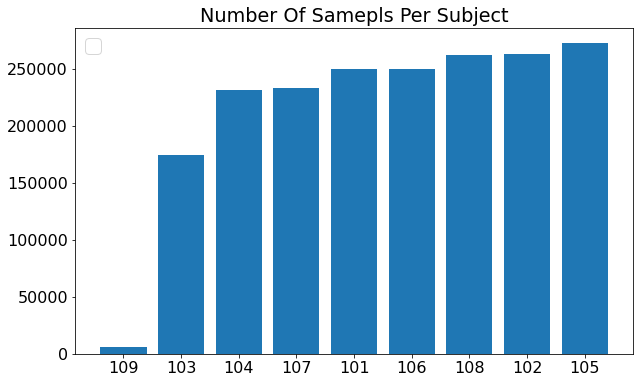

In [8]:
#present num of samples per subject
sampels = all_data.groupby(['subject_id']).count().reset_index()
sampels_to_subject = pd.DataFrame()
sampels_to_subject['id'] = sampels['subject_id']
sampels_to_subject['sampels'] = sampels['timestamp']
sampels_to_subject = sampels_to_subject.sort_values(by=['sampels'])
plot_samples(sampels_to_subject,'sampels','id','Number Of Samepls Per Subject')

data is balanced for samples per subject, excepts subject 109 which has very little amount of samples

No handles with labels found to put in legend.


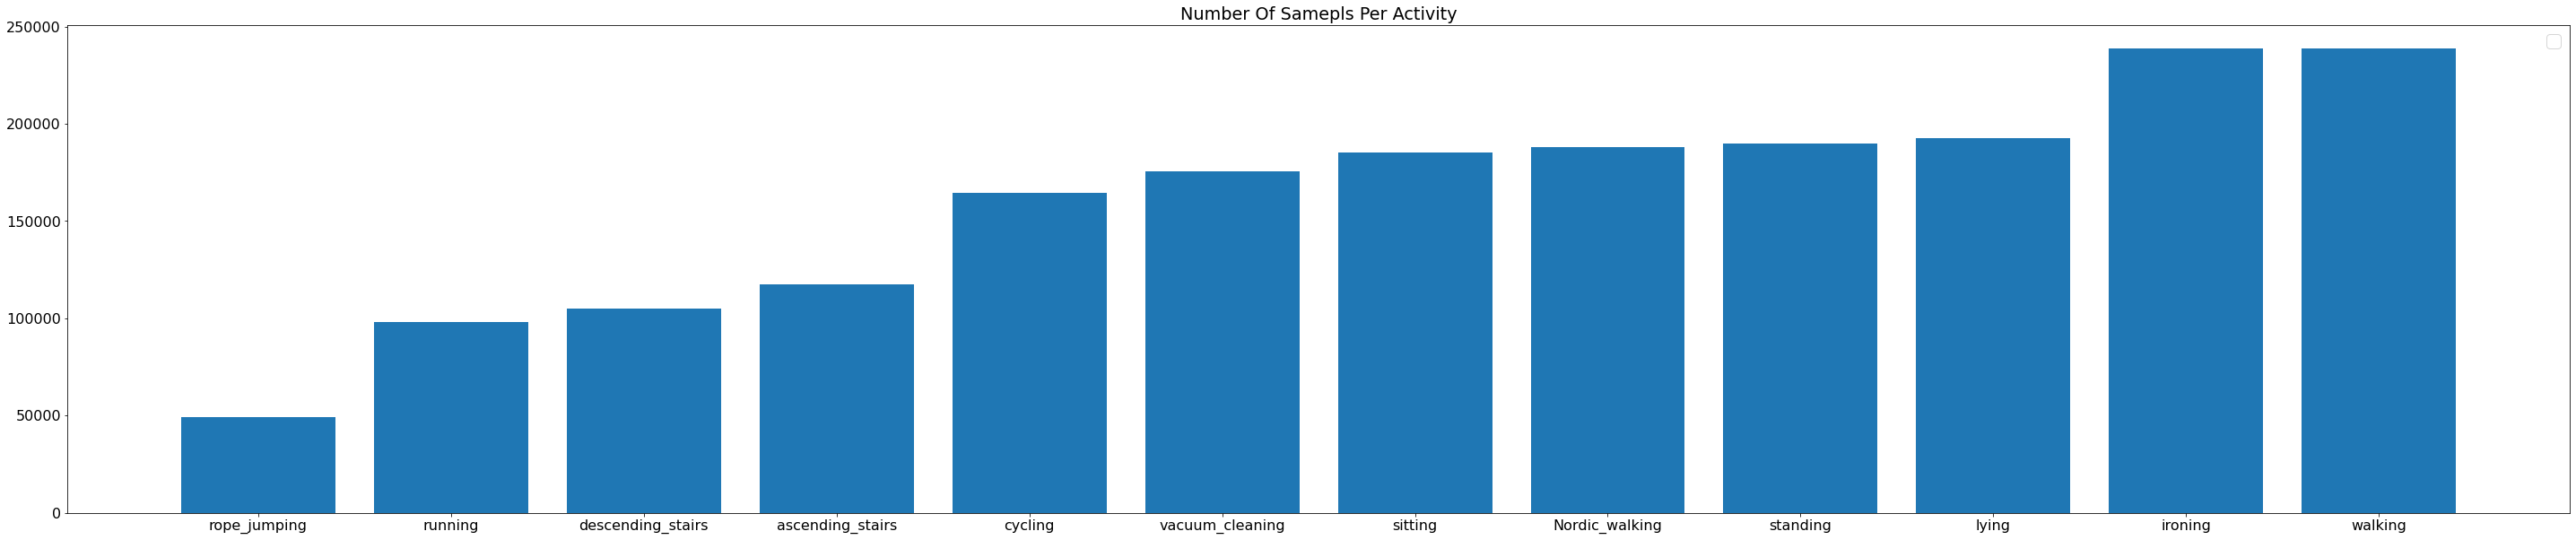

In [9]:
sampels = all_data.groupby(['activityID']).count().reset_index()
sampels_to_subject = pd.DataFrame()
sampels_to_subject['activity'] = [activityIDdict[x] for x in sampels['activityID']]
sampels_to_subject['sampels'] = sampels['timestamp']
sampels_to_subject = sampels_to_subject.sort_values(by=['sampels'])
plot_samples(sampels_to_subject,'sampels','activity','Number Of Samepls Per Activity',figsize=(50,10))
del sampels_to_subject

rope jumping has significally less samples - the data isn't totally balanced 

No handles with labels found to put in legend.


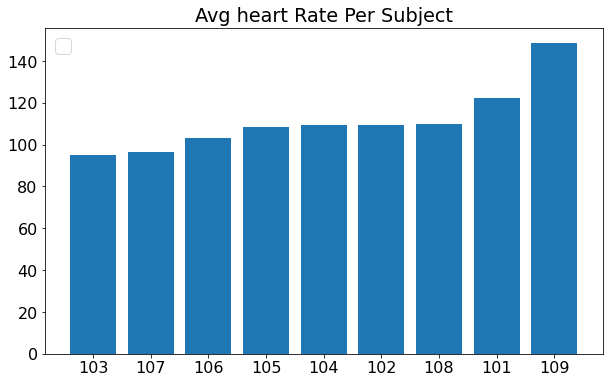

In [10]:
sampels_heart_rate = pd.DataFrame()
sampels_heart_rate['id'] = result_id['subject_id']
sampels_heart_rate['heartrate'] = result_id['heartrate']
sampels_heart_rate = sampels_heart_rate.sort_values(by=['heartrate'])
plot_samples(sampels_heart_rate,'heartrate','id','Avg heart Rate Per Subject')

No handles with labels found to put in legend.


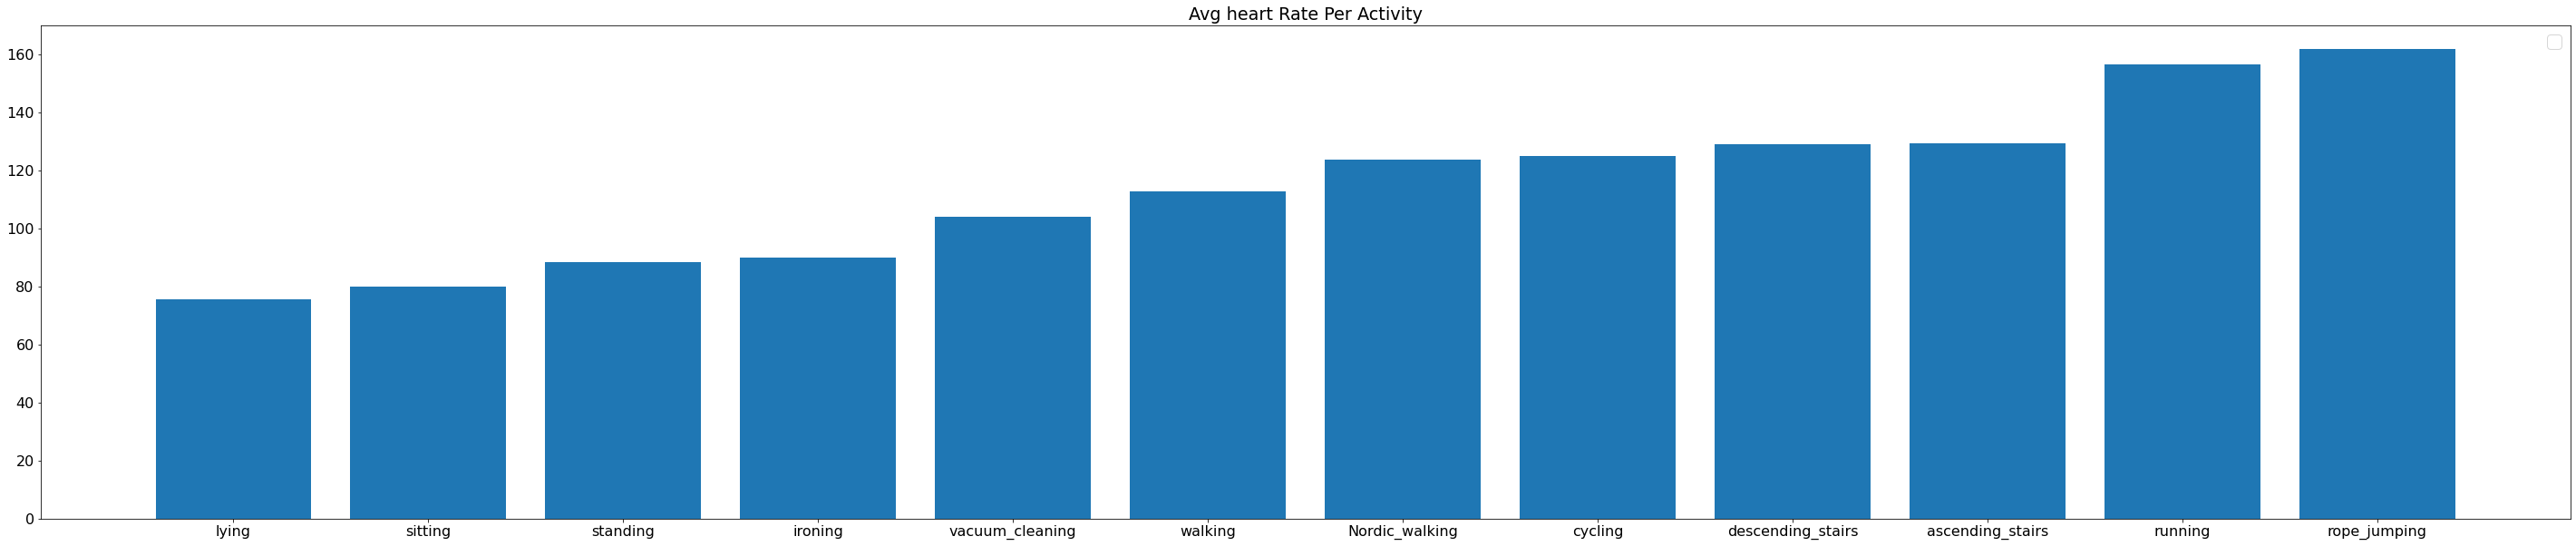

             activity   heartrate
0               lying   75.540579
1             sitting   80.012614
2            standing   88.554771
10            ironing   90.062321
9     vacuum_cleaning  104.194956
3             walking  112.786174
6      Nordic_walking  123.829853
5             cycling  124.884246
8   descending_stairs  129.156243
7    ascending_stairs  129.525475
4             running  156.590944
11       rope_jumping  161.985048


In [11]:
sampels_heart_rate = pd.DataFrame()
sampels_heart_rate['activity'] = [activityIDdict[x] for x in result_act['activityID']]
sampels_heart_rate['heartrate'] = result_act['heartrate']
sampels_heart_rate = sampels_heart_rate.sort_values(by=['heartrate'])

plot_samples(sampels_heart_rate,'heartrate','activity','Avg heart Rate Per Activity',figsize=(50,10))

print(sampels_heart_rate)

del sampels_heart_rate

        hand      chest      ankle
0  32.422762  35.234328  33.664982
1  32.335509  36.329871  34.252763
2  31.886316  35.801542  33.531945
3  31.901968  35.123014  33.577852
4  34.769571  37.446359  34.203705
5  32.300070  35.831370  34.721871
6  32.946647  36.767444  32.233119
7  33.154257  36.700240  33.345786
8  25.051254  32.235624  31.423193


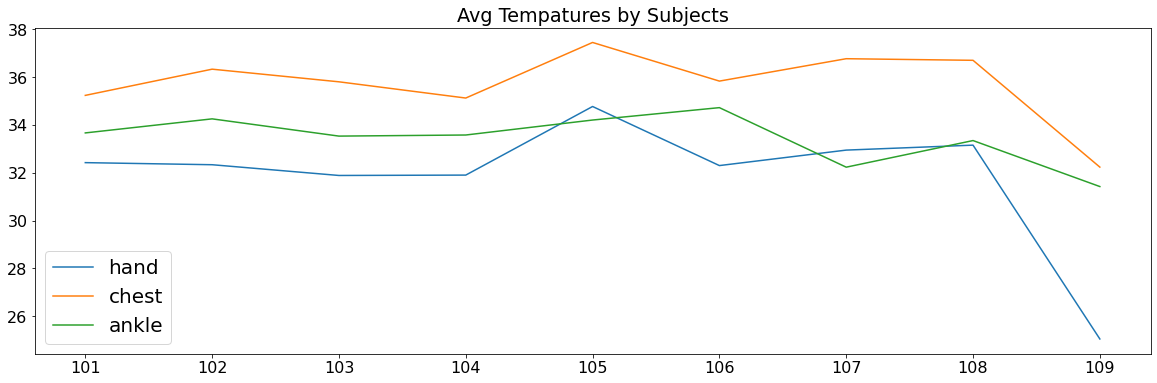

In [12]:
samepls_tempreture = pd.DataFrame()
samepls_tempreture['hand'] = result_id['handTemperature']
samepls_tempreture['chest'] = result_id['chestTemperature']
samepls_tempreture['ankle'] = result_id['ankleTemperature']
print(samepls_tempreture)

ax = samepls_tempreture.plot(kind='line', figsize=(20,6), title='Avg Tempatures by Subjects')
a = ax.set_xticklabels(result_id['subject_id'])
b = ax.legend(fontsize = 20)
c = ax.set_xticks(np.arange(len(samepls_tempreture)))
del samepls_tempreture

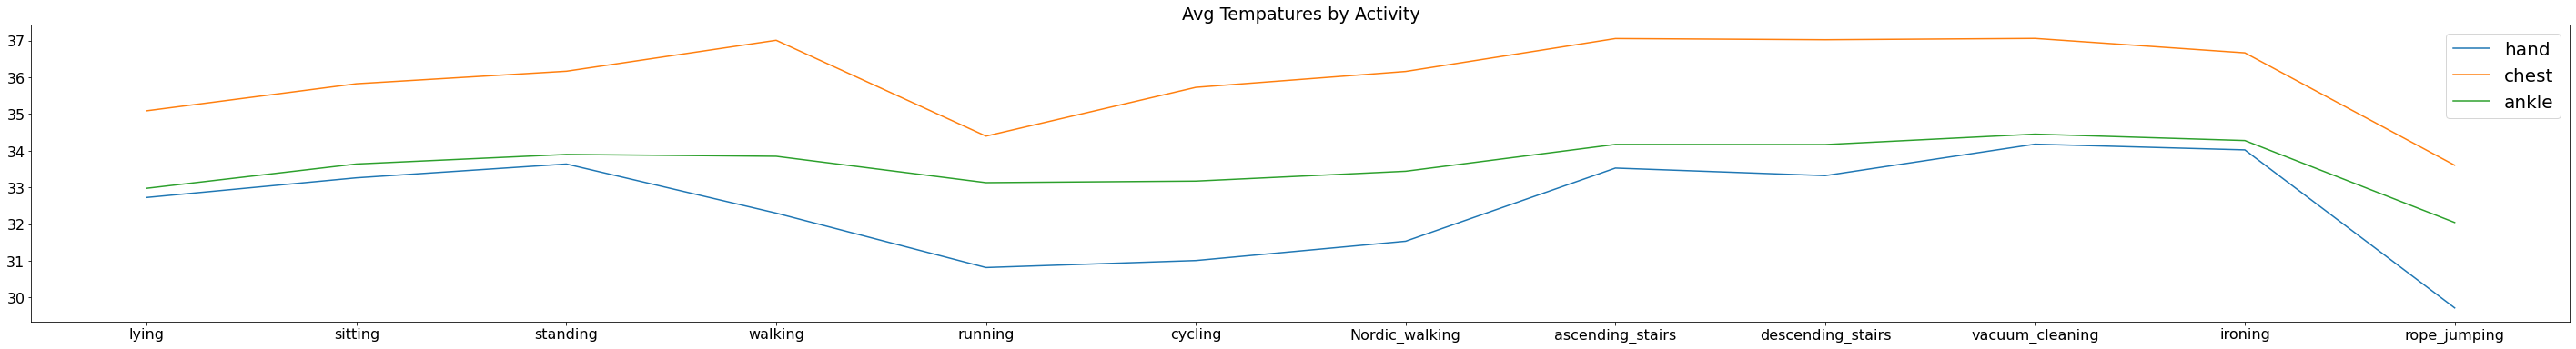

In [13]:
samepls_tempreture = pd.DataFrame()
samepls_tempreture['activity'] = [activityIDdict[x] for x in result_act['activityID']]
samepls_tempreture['hand'] = result_act['handTemperature']
samepls_tempreture['chest'] = result_act['chestTemperature']
samepls_tempreture['ankle'] = result_act['ankleTemperature']
ax = samepls_tempreture.plot(kind='line', figsize=(50,6), title='Avg Tempatures by Activity')
a = ax.set_xticklabels(samepls_tempreture['activity'])
b = ax.legend(fontsize = 20)
c = ax.set_xticks(np.arange(len(samepls_tempreture)))


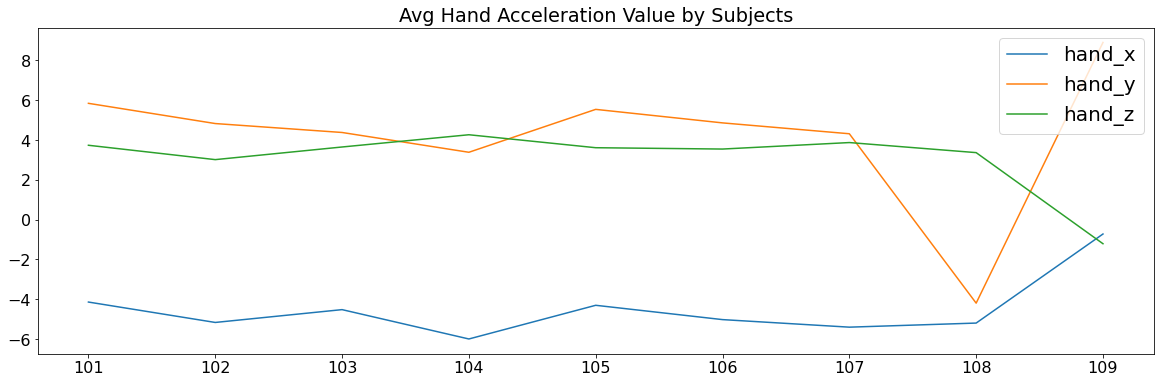

In [14]:
samepls = pd.DataFrame()
samepls['hand_x'] = result_id['handAcc16_x']
samepls['hand_y'] = result_id['handAcc16_y']
samepls['hand_z'] = result_id['handAcc16_z']
ax = samepls.plot(kind='line', figsize=(20,6), title='Avg Hand Acceleration Value by Subjects')
a = ax.set_xticklabels(result_id['subject_id'])
b = ax.legend(fontsize = 20)
c = ax.set_xticks(np.arange(len(samepls)))

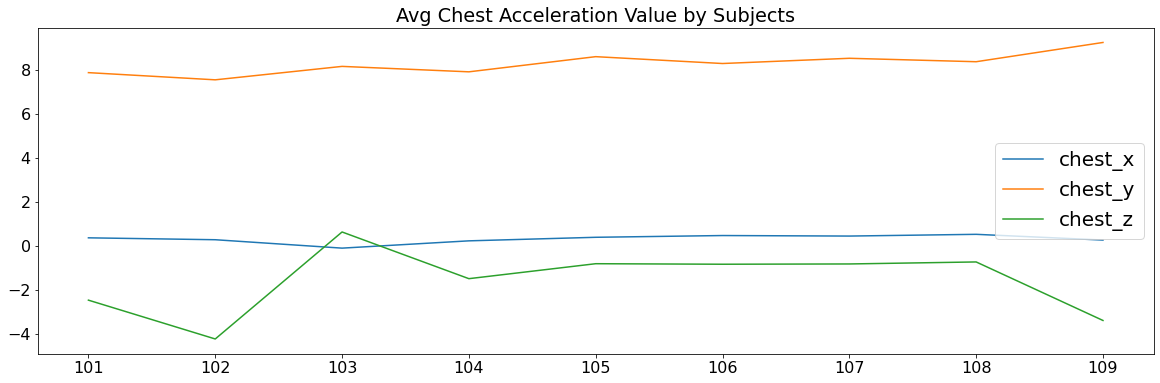

In [15]:
samepls = pd.DataFrame()
samepls['chest_x'] = result_id['chestAcc16_x']
samepls['chest_y'] = result_id['chestAcc16_y']
samepls['chest_z'] = result_id['chestAcc16_z']
ax = samepls.plot(kind='line', figsize=(20,6), title='Avg Chest Acceleration Value by Subjects')
a = ax.set_xticklabels(result_id['subject_id'])
b = ax.legend(fontsize = 20)
c = ax.set_xticks(np.arange(len(samepls)))

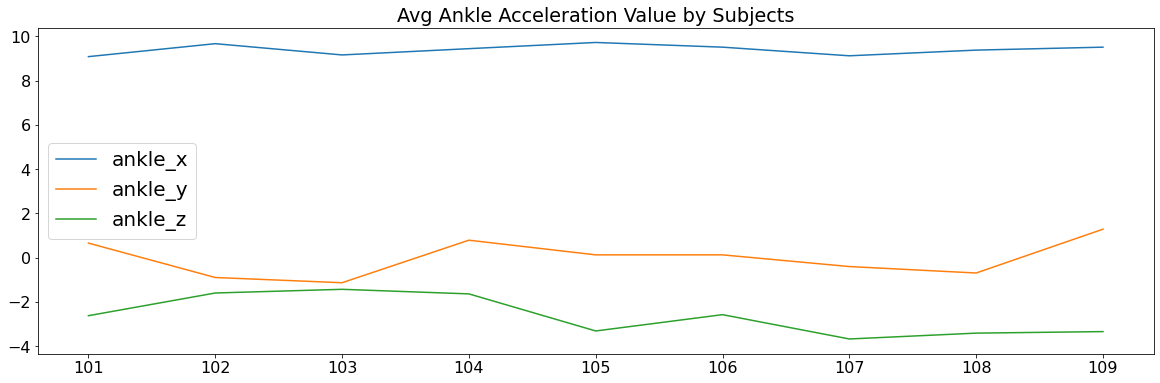

In [16]:
samepls = pd.DataFrame()
samepls['ankle_x'] = result_id['ankleAcc16_x']
samepls['ankle_y'] = result_id['ankleAcc16_y']
samepls['ankle_z'] = result_id['ankleAcc16_z']
ax = samepls.plot(kind='line', figsize=(20,6), title='Avg Ankle Acceleration Value by Subjects')
a = ax.set_xticklabels(result_id['subject_id'])
b = ax.legend(fontsize = 20)
c = ax.set_xticks(np.arange(len(samepls)))
del samepls

In [17]:
!pip install heatmapz

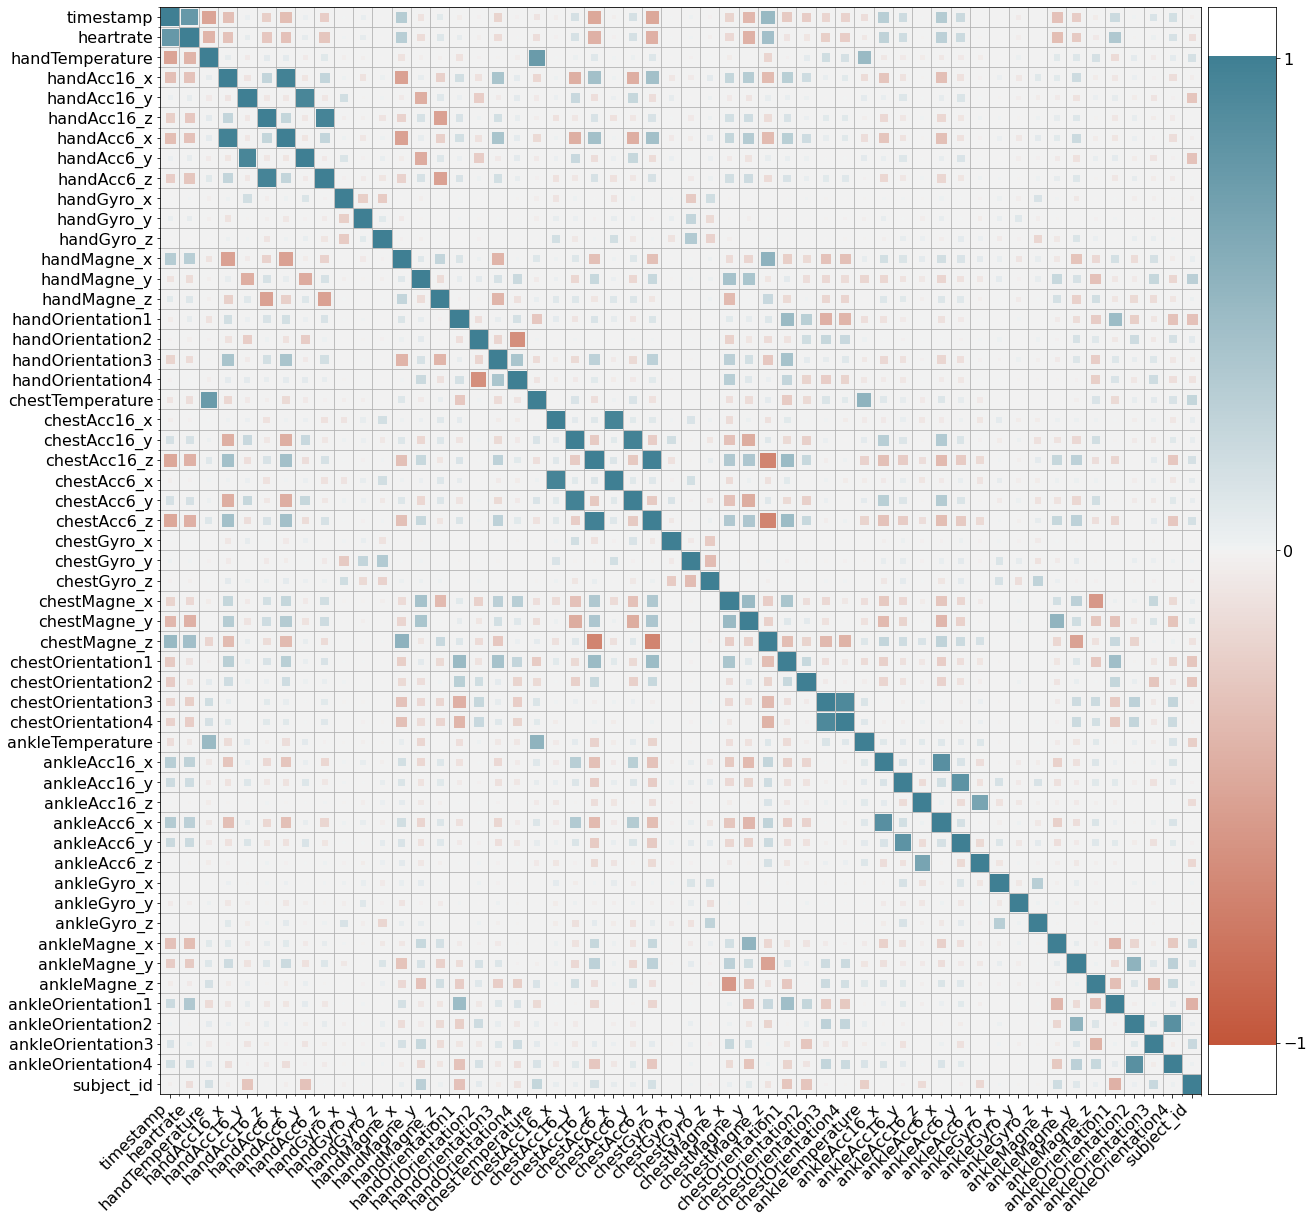

In [18]:
from heatmap import heatmap, corrplot
dropped_activity = all_data.drop(['activityID'], axis = 1)

plt.figure(figsize=(20, 20))
corrplot(dropped_activity.corr(), size_scale=300);
del dropped_activity

# Q2 :


a. Decide your validation strategy for training your model 

we will use for train set subjects 101-105 and 109.

subject 106 will be the validation set.

subjects 107-108 will use for test set.

In [19]:
def get_train_test(all_data):
  # create the test data
  subject107 = all_data[all_data['subject_id'] == 107]
  subject108 = all_data[all_data['subject_id'] == 108]
  test = subject107.append(subject108)

  #create validate data
  valid_train = all_data[all_data['subject_id'] == 106]
  valid_test = valid_train['activityID']
  valid_train = valid_train.drop(['activityID'], axis=1)

  # create the train data
  train = all_data[all_data['subject_id'] != 107]
  train = all_data[all_data['subject_id'] != 108]
  train = all_data[all_data['subject_id'] != 106]


  # # drop the columns id
  test = test.drop(["subject_id"], axis=1) # 107-108
  train = train.drop(["subject_id"], axis=1) # all the rest
  valid_train = valid_train.drop(['subject_id'], axis=1)


  # split train and test to X and y
  x_train = train.drop(['activityID'], axis=1)
  x_test = test.drop(['activityID'], axis=1)
  y_train = train['activityID']
  y_test = test['activityID']

  return x_train, x_test, valid_train, valid_test, y_train, y_test

x_train, x_test,valid_train, valid_test, y_train, y_test = get_train_test(all_data)



b.	Create a naïve baseline solution and calculate train and validation score for that solution. This could be predicting last known value, or prediction of the class distribution for each category.


we will try to create a baseline by mean of heartrate and mean of hand temp to decide which activity was perfomed


In [20]:
b = pd.DataFrame()
b['activity'] = [activityIDdict[x] for x in result_act['activityID']]
b['heartrate'] = result_act['heartrate']
b['handTemp'] = result_act['handTemperature']
b['act_index'] = [activityNameToIdDict[y] for y in b['activity']]
b.set_index('act_index', inplace=True)
b.sort_values(by=['heartrate', 'handTemp'])

,activity,heartrate,handTemp
act_index,,,
1,lying,75.540579,32.726154
2,sitting,80.012614,33.262088
3,standing,88.554771,33.637791
17,ironing,90.062321,34.022834
16,vacuum_cleaning,104.194956,34.178360
4,walking,112.786174,32.300379
7,Nordic_walking,123.829853,31.534647
6,cycling,124.884246,31.008824
13,descending_stairs,129.156243,33.322055


In [21]:
import random

def choose_random_activity(id1,id2):
  rand = random.randint(0, 1)
  if rand == 0:
    return id1

  return id2


def rule_based_baseline(record):

    heart_rate = record['heartrate']
    hand_temp = record['handTemperature']
    activity = 0      
    
    if heart_rate < 95:
      # Activities: 1,2,3,17
      if hand_temp < 33:
        activity = 1
      elif hand_temp < 34 and hand_temp >= 33:
        activity = choose_random_activity(2,3)
      else:
        activity = 17

      
    elif heart_rate < 118:
      # Activities:  16,4
      if(hand_temp < 33):
        activity = 4
      else:
        activity = 16      


    elif heart_rate < 140:
      # Activities:  6,7,13,12
      if hand_temp < 32.3 :
        activity = choose_random_activity(6,7)
      else:
        activity = choose_random_activity(12,13)

      

    elif heart_rate >= 140:
      # Activities: 5,24
      if hand_temp < 30.2:
        activity = 24
      else:
        activity = 5
      

    return activity



In [22]:
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss

def get_preds_from_baseline(df):
  
  y_preds = []

  for idx,record in df.iterrows():
    pred = rule_based_baseline(record)
    y_preds.append(pred)

  return y_preds

y_preds_train = get_preds_from_baseline(x_train)
print('train base line results:')
print(accuracy_score(y_preds_train, y_train))

train base line results:
0.31911487402940497


In [23]:
y_preds_valid = get_preds_from_baseline(valid_train)
print('validation base line results:')
print(accuracy_score(y_preds_valid, valid_test))

validation base line results:
0.36646327810120916


In [24]:
y_preds_test = get_preds_from_baseline(x_test)
print('test base line results:')
print(accuracy_score(y_preds_test, y_test))

test base line results:
0.32744636051713755


we can see that the baseline isn't that bad so heartrate and handTemp has a significance but that is not enough.

In [25]:
del x_train ,x_test ,valid_train, valid_test, y_train, y_test
del y_preds_train, y_preds_valid, y_preds_test

c.	Fit a classical machine learning model to the data and get a better and solid benchmark for the neural network model.
Think which features will be useful for such a model

In [26]:
def get_train_valid_test_all_cols_by_subject(data):
  # create the test data
  subject107 = data[data['subject_id'] == 107]
  subject108 = data[data['subject_id'] == 108]
  test_df = subject107.append(subject108)

  #create validate data
  valid_df = data[data['subject_id'] == 106]

  # create the train data
  train_df = data[data['subject_id'] != 107]
  train_df = data[data['subject_id'] != 108]
  train_df = data[data['subject_id'] != 106]

  return train_df, valid_df, test_df

train_df, valid_df, test_df = get_train_valid_test_all_cols_by_subject(all_data)
train_df

,timestamp,activityID,heartrate,handTemperature,handAcc16_x,handAcc16_y,handAcc16_z,handAcc6_x,handAcc6_y,handAcc6_z,handGyro_x,handGyro_y,handGyro_z,handMagne_x,handMagne_y,handMagne_z,handOrientation1,handOrientation2,handOrientation3,handOrientation4,chestTemperature,chestAcc16_x,chestAcc16_y,chestAcc16_z,chestAcc6_x,chestAcc6_y,chestAcc6_z,chestGyro_x,chestGyro_y,chestGyro_z,chestMagne_x,chestMagne_y,chestMagne_z,chestOrientation1,chestOrientation2,chestOrientation3,chestOrientation4,ankleTemperature,ankleAcc16_x,ankleAcc16_y,ankleAcc16_z,ankleAcc6_x,ankleAcc6_y,ankleAcc6_z,ankleGyro_x,ankleGyro_y,ankleGyro_z,ankleMagne_x,ankleMagne_y,ankleMagne_z,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
2928,37.66,1,107.487925,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,-0.004750,0.037579,-0.011145,8.93200,-67.9326,-19.9755,1.000000,0.000000,0.000000,0.000000,32.1875,0.124482,9.65003,-1.65181,0.143941,9.71019,-1.47347,0.036668,0.016559,-0.052791,0.567566,-50.7269,44.2728,1.000000,0.000000,0.000000,0.000000,30.75,9.73855,-1.84761,0.095156,9.63162,-1.76757,0.265761,0.002908,-0.027714,0.001752,-61.1081,-36.863600,-58.369600,1.000000,0.000000,0.000000,0.000000,101
2929,37.67,1,107.487925,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,-0.171710,0.025479,-0.009538,9.58300,-67.9584,-20.9091,1.000000,0.000000,0.000000,0.000000,32.1875,0.200711,9.64980,-1.65043,0.129092,9.74041,-1.47329,0.019343,-0.024304,-0.059843,0.904990,-50.5080,43.5427,1.000000,0.000000,0.000000,0.000000,30.75,9.69762,-1.88438,-0.020804,9.58649,-1.75247,0.250816,0.020882,0.000945,0.006007,-60.8916,-36.319700,-58.365600,1.000000,0.000000,0.000000,0.000000,101
2930,37.68,1,107.487925,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,-0.238241,0.011214,0.000831,9.05516,-67.4017,-19.5083,1.000000,0.000000,0.000000,0.000000,32.1875,0.270277,9.72331,-1.88174,0.144685,9.77048,-1.41285,-0.001428,0.038466,-0.046464,0.455480,-50.7209,44.0259,1.000000,0.000000,0.000000,0.000000,30.75,9.69633,-1.92203,-0.059173,9.60196,-1.73721,0.356632,-0.035392,-0.052422,-0.004882,-60.3407,-35.784200,-58.611900,1.000000,0.000000,0.000000,0.000000,101
2931,37.69,1,107.487925,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,-0.192912,0.019053,0.013374,9.92698,-67.4387,-20.5602,1.000000,0.000000,0.000000,0.000000,32.1875,0.236737,9.72447,-1.72746,0.174402,9.75538,-1.45841,0.017277,-0.048547,-0.074946,0.324284,-50.1544,43.6570,1.000000,0.000000,0.000000,0.000000,30.75,9.66370,-1.84714,0.094385,9.58674,-1.78264,0.311453,-0.032514,-0.018844,0.026950,-60.7646,-37.102800,-57.879900,1.000000,0.000000,0.000000,0.000000,101
2932,37.70,1,100.000000,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,-0.069961,-0.018328,0.004582,9.15626,-67.1825,-20.0857,1.000000,0.000000,0.000000,0.000000,32.1875,0.352225,9.72437,-1.68665,0.173568,9.69512,-1.53414,0.000275,-0.013352,-0.039315,0.462317,-50.7110,42.9228,1.000000,0.000000,0.000000,0.000000,30.75,9.77578,-1.88582,0.095775,9.64677,-1.75240,0.295902,0.001351,-0.048878,-0.006328,-60.2040,-37.122500,-57.884700,1.000000,0.000000,0.000000,0.000000,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872015,95.06,24,162.000000,25.125,4.99466,6.01881,5.59830,4.90787,6.05780,5.68357,-0.289166,-0.110170,0.238570,-4.79353,-18.1271,-48.2695,0.823022,-0.256932,0.401650,0.308704,32.3750,-0.385331,9.42255,-2.12496,-0.567952,9.48622,-2.05921,-0.147595,-0.137509,0.066513,20.755500,-35.3089,25.0120,0.599802,-0.710880,-0.305108,-0.204444,31.50,9.40727,-2.24401,-2.259740,9.41274,-2.26922,-1.759580,0.021288,-0.012885,0.005878,-45.7855,-0.831734,-0.170139,0.522929,-0.291612,0.705786,-0.378648,109
2872016,95.07,24,162.000000,25.125,5.02764,5.90369,5.48372,4.89090,5.95209,5.56301,-0.275411,-0.128358,0.267409,-4.54101,-18.0169,-48.9268,0.823742,-

we chose the most correlated columns in data to be trained and tested

In [27]:

relevant_cols_by_corr_table = ['timestamp', 'activityID','heartrate','subject_id','handTemperature', 
           'handAcc16_x', 'handAcc16_y', 'handAcc16_z', 
           'handAcc6_x', 'handAcc6_y', 'handAcc6_z', #'handGyro_x', 'handGyro_y', 'handGyro_z',
           'chestTemperature', 
           'chestAcc16_x', 'chestAcc16_y', 'chestAcc16_z', 
           'chestAcc6_x', 'chestAcc6_y', 'chestAcc6_z', #'chestGyro_x', 'chestGyro_y', 'chestGyro_z',
           'ankleTemperature', 
           'ankleAcc16_x', 'ankleAcc16_y', 'ankleAcc16_z', 
           'ankleAcc6_x', 'ankleAcc6_y', 'ankleAcc6_z' ] #,'ankleGyro_x', 'ankleGyro_y', 'ankleGyro_z',]



In [28]:
train_df = train_df[relevant_cols_by_corr_table]
valid_df = valid_df[relevant_cols_by_corr_table]
test_df = test_df[relevant_cols_by_corr_table]
del all_data
# train_df

In [29]:
from tensorflow.keras.utils import to_categorical
from tqdm.notebook import tqdm
tqdm.pandas()

def get_timeSeries_window_data(df, window_back, jump_by, label, is_categorical):
  x = pd.DataFrame(columns=relevant_cols_by_corr_table)
  y = pd.DataFrame(columns=['activityID'])
  df_copy = df.copy()
  subject_list = df_copy.subject_id.unique()
  activity_list = df_copy.activityID.unique()

  for sub in tqdm(subject_list, desc='subject'):
    for act in tqdm(activity_list, desc='target'):
      subject_activity_df = df_copy[(df_copy.subject_id == sub) & (df_copy.activityID == act)]
      subject_activity_df = subject_activity_df.drop(columns=['subject_id'])

      activity_df = pd.DataFrame(data=subject_activity_df[label], columns=['activityID'])
      # print(activity_df)
      subject_activity_df = subject_activity_df.drop(columns=[label])

      for i in range(window_back, subject_activity_df.shape[0], jump_by):
        # first_row = subject_activity_df.iloc[i-window_back]
        # last_row = subject_activity_df.iloc[i]

        # first_row_time = first_row['timestamp']
        # last_row_time = last_row['timestamp']
        # # print(last_row_time - first_row_time)
        # if last_row_time - first_row_time != 2:
        #   continue

        prev_window = subject_activity_df[i-window_back:i]
        prev_win_mean = prev_window.rolling(window=window_back).mean()
        x = x.append(prev_win_mean.tail(1),ignore_index=True)

        # print(type(prev_window))
        # print(prev_window)
        # print('==================================================================')
        # print(prev_window.rolling(window=window_back).mean())
        
        # print(i)
        # print(activity_df.iloc[i])
        # print(activity_df)
        # print(activity_df.index[0])
        # index = activity_df.index[0] + 200
        # print(index)
        prev_window_act = activity_df[i-window_back:i]
        # print(prev_window_act.tail(1))

        y = y.append(prev_window_act.tail(1), ignore_index=True )

        # print(x,y)
      #   break
      # break

    x = x.drop(columns=['activityID','subject_id'])
    return x, y


In [30]:
window_back = 200
label = 'activityID'
is_categorical = True
jump_by = 50

# bla , blabla = get_timeSeries_window_data(train_df, window_back, jump_by, label, True)
x_train, y_train = get_timeSeries_window_data(train_df, window_back, jump_by, label, True)
x_val, y_val = get_timeSeries_window_data(valid_df, window_back, jump_by, label, True)
x_test, y_test = get_timeSeries_window_data(test_df, window_back, jump_by, label, True)
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))
print(len(x_test))
print(len(y_test))
print('==================================================================')

print(x_train)
print(y_train)



4957
4957
4959
4959
4617
4617
      timestamp   heartrate  ...  ankleAcc6_y  ankleAcc6_z
0        38.655  100.934759  ...    -1.788640     0.288300
1        39.155  101.160000  ...    -1.663571     0.335720
2        39.655  101.410000  ...    -1.456063     0.385594
3        40.155  101.660000  ...    -1.252686     0.459962
4        40.655  101.910000  ...    -1.058728     0.499823
...         ...         ...  ...          ...          ...
4952   3623.255  183.000000  ...     1.907951    -0.396688
4953   3623.755  183.000000  ...     1.862365    -0.538150
4954   3624.255  183.000000  ...     1.833564    -0.591588
4955   3624.755  183.000000  ...     1.845451    -0.579274
4956   3625.255  183.000000  ...     1.920877    -0.554096

[4957 rows x 23 columns]
     activityID
0             1
1             1
2             1
3             1
4             1
...         ...
4952         24
4953         24
4954         24
4955         24
4956         24

[4957 rows x 1 columns]


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression(solver='lbfgs', max_iter=1000)
ranForest = RandomForestClassifier()

y_train = y_train.astype('int')

logReg.fit(x_train, y_train)
ranForest.fit(x_train, y_train)



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using r

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [32]:

logReg_preds_valid = logReg.predict(x_val)
ranForest_preds_valid = ranForest.predict(x_val)

y_val = y_val.astype('int')

print(f'Random Forest accuracy on validation: {accuracy_score(ranForest_preds_valid, y_val)}')
print(f'Logistic Regression accuracy on validation: {accuracy_score(logReg_preds_valid, y_val)}')


Random Forest accuracy on validation: 0.5753176043557169
Logistic Regression accuracy on validation: 0.5854002823149829


In [33]:

logReg_preds_test = logReg.predict(x_test)
ranForest_preds_test = ranForest.predict(x_test)

y_test = y_test.astype('int')

# print(f'SVM accuracy on test: {accuracy_score(dtree_preds_test, y_test)}')
print(f'Random Forest accuracy on test: {accuracy_score(ranForest_preds_test, y_test)}')
print(f'Logistic Regression accuracy on test: {accuracy_score(logReg_preds_test, y_test)}')


Random Forest accuracy on test: 0.5653021442495126
Logistic Regression accuracy on test: 0.723846653671215


pretty good results for logistic regression and solid result for randomForest

In [34]:
del x_train, x_test, x_val, y_val, y_train, y_test

# d.	Construct a neural network model and fit it to the data. analyze the results (Use visualizations to present your loss and other metrics you find relevant, show examples for good and bad classification with high probability, and refer to the uncertain predictions.  

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model

In [36]:
def plot_results(history):
    #accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [37]:
from sklearn.preprocessing import MinMaxScaler

def get_scaled_data(df,label):
  scaler = MinMaxScaler(feature_range=(0, 1))
  y_t_df = df[[label]]
  x_t_df = df.copy()
  x_t_df = x_t_df.drop([label], axis=1)
  x_t_df_scaled = scaler.fit_transform(x_t_df)
  x_t = []
  y_t = []
  win = 200
  for i in range(win,x_t_df_scaled.shape[0],50):
    x_t.append(x_t_df_scaled[i-win:i,:])
    y_t.append(y_t_df.iloc[i])
  
  return np.array(x_t) , np.array(y_t)

x_train, y_train = get_scaled_data(train_df,'activityID')


In [38]:
x_val, y_val = get_scaled_data(valid_df,'activityID')

In [39]:
from sklearn.preprocessing import OneHotEncoder
hot = OneHotEncoder(handle_unknown='ignore', sparse=False)

y_train_ohe = hot.fit_transform(y_train)
print(hot.categories_)

y_val_ohe = hot.fit_transform(y_val)

# print( y_train_ohe[0] )
# print( y_train_ohe[1] )
# print( y_train_ohe[2] )
# print( y_train_ohe[3] )
# print( y_train_ohe[4] )
# print( y_train_ohe[5] )
# print( y_train_ohe[6] )
# print( y_train_ohe[7] )
# print( y_train_ohe[8] )
# print( y_train_ohe[9] )
# print( y_train_ohe[10] )
# print( y_train_ohe[11] )
# print('=======================================================')
# invert = hot.inverse_transform(y_train_ohe)
# print(invert[2000])
y_val_ohe.shape

[array([ 1,  2,  3,  4,  5,  6,  7, 12, 13, 16, 17, 24])]


(4998, 12)

In [40]:
def create_callbacks(path, patience=5, factor=0.1, monitor='val_loss', save_best=True):
    es = EarlyStopping(monitor=monitor, patience=patience, verbose=1,)
    rlr = ReduceLROnPlateau(monitor=monitor, factor=factor, patience=patience)
    model_ckpt = ModelCheckpoint(path, monitor=monitor, save_best_only=save_best)
    return [es, rlr, model_ckpt]

In [41]:
num = 4

In [42]:
path_to_save_model_activity = r'drive/My Drive/DeepLearnCourse/ass2/model_best_activity'+str(num)+'.h5'

model_activity = Sequential()
model_activity.add(LSTM(24, input_shape=(x_train.shape[1],x_train.shape[2]), return_sequences=True))
model_activity.add(Dense(24))
model_activity.add(LSTM(12, return_sequences=False))
model_activity.add(Dense(12))
model_activity.add(Dense(y_train_ohe.shape[1],activation='softmax'))
model_activity.compile( optimizer= 'adam',loss='categorical_crossentropy', metrics=['accuracy'])
model_activity.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200, 24)           4704      
_________________________________________________________________
dense (Dense)                (None, 200, 24)           600       
_________________________________________________________________
lstm_1 (LSTM)                (None, 12)                1776      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                156       
Total params: 7,392
Trainable params: 7,392
Non-trainable params: 0
_________________________________________________________________


In [43]:
history_act = model_activity.fit(x_train, y_train_ohe, batch_size=128, epochs=10, validation_data=(x_val, y_val_ohe),
                      callbacks=create_callbacks(path=path_to_save_model_activity))

Epoch 1/10
265/265 [==============================] - 15s 24ms/step - loss: 1.8886 - accuracy: 0.3093 - val_loss: 1.6915 - val_accuracy: 0.3391
Epoch 2/10
265/265 [==============================] - 5s 20ms/step - loss: 0.9042 - accuracy: 0.6375 - val_loss: 1.5107 - val_accuracy: 0.4158
Epoch 3/10
265/265 [==============================] - 5s 20ms/step - loss: 0.7652 - accuracy: 0.7033 - val_loss: 1.7346 - val_accuracy: 0.3371
Epoch 4/10
265/265 [==============================] - 5s 20ms/step - loss: 0.6233 - accuracy: 0.7460 - val_loss: 1.8654 - val_accuracy: 0.4202
Epoch 5/10
265/265 [==============================] - 5s 20ms/step - loss: 0.5773 - accuracy: 0.7603 - val_loss: 1.5074 - val_accuracy: 0.4606
Epoch 6/10
265/265 [==============================] - 5s 20ms/step - loss: 0.4605 - accuracy: 0.8147 - val_loss: 1.4776 - val_accuracy: 0.5204
Epoch 7/10
265/265 [==============================] - 5s 20ms/step - loss: 0.4180 - accuracy: 0.8215 - val_loss: 1.2610 - val_accuracy: 0.618

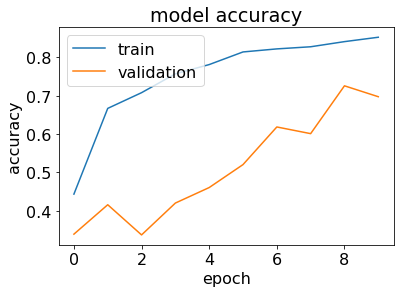

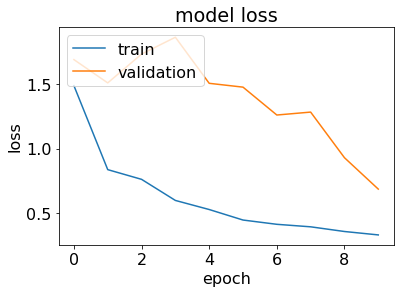

In [44]:
plot_results(history_act)

In [45]:
x_test, y_test= get_scaled_data(test_df,'activityID')


In [46]:
y_test_ohe = hot.fit_transform(y_test)

In [47]:
model_activity.load_weights(path_to_save_model_activity)
model_activity.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [48]:
model_activity.evaluate(x_test, y_test_ohe)

310/310 [==============================] - 4s 9ms/step - loss: 1.6452 - accuracy: 0.4944


[1.3603885173797607, 0.5310289263725281]

In [49]:
y_test_origin = hot.inverse_transform(y_test_ohe)
preds = model_activity.predict(x_test)
ans = []
for array in preds:
  max_index = array.argmax(axis=0)
  a = np.zeros(array.shape[0])
  a[max_index] = 1
  ans.append(a)

ans_origin = hot.inverse_transform(ans)

In [50]:
def load_activity_map():
    map = {}
    map[0] = 'transient'
    map[1] = 'lying'
    map[2] = 'sitting'
    map[3] = 'standing'
    map[4] = 'walking'
    map[5] = 'running'
    map[6] = 'cycling'
    map[7] = 'Nordic_walking'
    map[9] = 'watching_TV'
    map[10] = 'computer_work'
    map[11] = 'car driving'
    map[12] = 'ascending_stairs'
    map[13] = 'descending_stairs'
    map[16] = 'vacuum_cleaning'
    map[17] = 'ironing'
    map[18] = 'folding_laundry'
    map[19] = 'house_cleaning'
    map[20] = 'playing_soccer'
    map[24] = 'rope_jumping'
    return map

In [51]:
def confusion_matrix_to_model(preds,true):
  # building a map of result to activity
  result = np.unique(preds).tolist() 
  expected = np.unique(true).tolist() 
  combined = list(zip(result,expected))
  conf_map = dict(combined)
  activity_map = load_activity_map()
  labels = [activity_map[conf_map[x]] for x in result]

  con = confusion_matrix(preds,true)
  a = plt.figure(figsize=(20,20), dpi=50)
  a = sns.heatmap(con, cmap='YlGnBu', annot=True, fmt = 'd', xticklabels=labels, yticklabels=labels)
  a = plt.rcParams.update({'font.size': 20})
  a = plt.title('Confusion Matrix')
  a = plt.xlabel('Predictions')
  a = plt.ylabel('True Label')

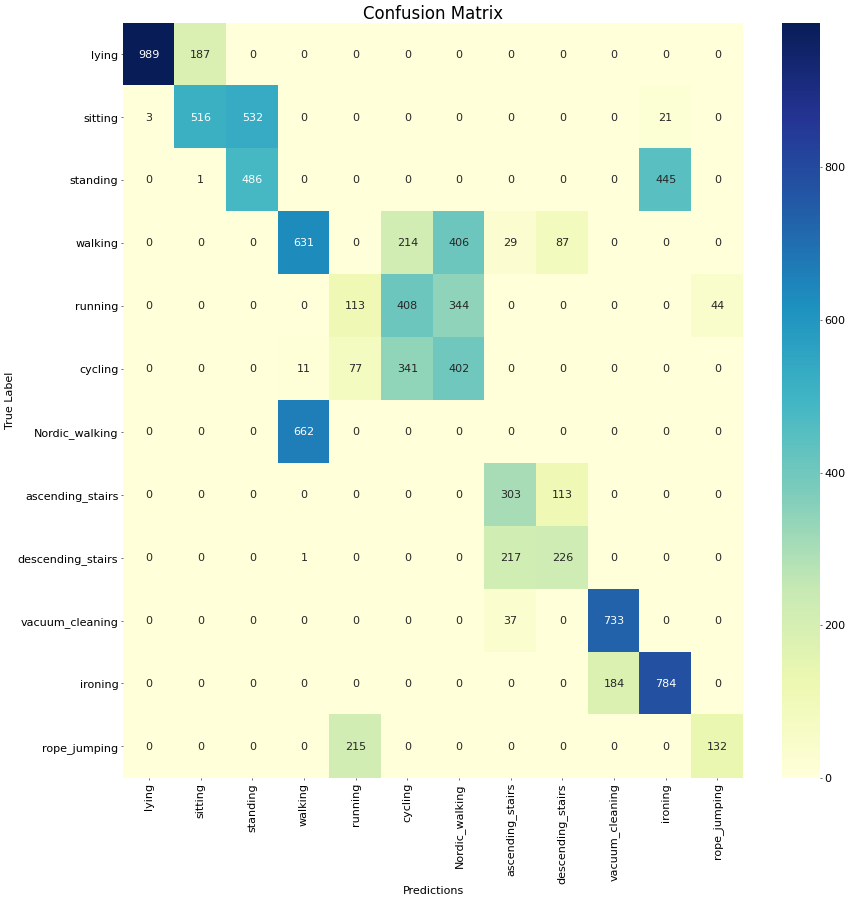

In [52]:
confusion_matrix_to_model(ans_origin,y_test_origin)


e.	Pretrain your model on the one of the tasks you suggested in 1c and fine tune the trained model to the data. compare the results you got to previous sections (c-d)

we chose to create a model that make self-supervied mission:
trying to predict the heart rate based on the other sensors and then used that model to predict the activity

In [53]:
del x_train, y_train, x_val, y_val, x_test, y_test

def get_scaled_data_hr(df,label):
  scaler = MinMaxScaler(feature_range=(0, 1))
  y_t_df = df[[label]]
  x_t_df = df.copy()
  # x_t_df = x_t_df.drop([label], axis=1)
  x_t_df_scaled = scaler.fit_transform(x_t_df)
  x_t = []
  y_t = []
  win = 200
  for i in range(win,x_t_df_scaled.shape[0],50):
    x_t.append(x_t_df_scaled[i-win:i,:])
    y_t.append(y_t_df.iloc[i])
  
  return np.array(x_t) , np.array(y_t)

x_train_hr, y_train_hr = get_scaled_data_hr(train_df,'heartrate')
x_val_hr, y_val_hr = get_scaled_data_hr(valid_df,'heartrate')
x_test_hr, y_test_hr = get_scaled_data_hr(test_df,'heartrate')


In [54]:
path_to_save_model_heartrate = r'drive/My Drive/DeepLearnCourse/ass2/model_best_heartrate'+str(num)+'.h5'

model_heartrate = Sequential()
model_heartrate.add(LSTM(64, input_shape=(x_train_hr.shape[1],x_train_hr.shape[2]),activation='tanh', return_sequences=False))
model_heartrate.add(Dense(32, activation='relu'))
model_heartrate.add(Dense(y_train_hr.shape[1], activation='relu'))

model_heartrate.compile(optimizer='adam', loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
model_heartrate.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                23040     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 25,153
Trainable params: 25,153
Non-trainable params: 0
_________________________________________________________________


In [55]:
history_hr = model_heartrate.fit(x_train_hr, y_train_hr, batch_size=128, epochs=20, validation_data=(x_val_hr, y_val_hr),
                    callbacks=create_callbacks(path=path_to_save_model_heartrate))

Epoch 1/20
265/265 [==============================] - 5s 14ms/step - loss: 7365.6691 - mae: 76.6523 - root_mean_squared_error: 84.4499 - val_loss: 798.9985 - val_mae: 22.8131 - val_root_mean_squared_error: 28.2666
Epoch 2/20
265/265 [==============================] - 3s 12ms/step - loss: 720.0885 - mae: 22.0366 - root_mean_squared_error: 26.8334 - val_loss: 800.5944 - val_mae: 22.8705 - val_root_mean_squared_error: 28.2948
Epoch 3/20
265/265 [==============================] - 3s 12ms/step - loss: 711.3666 - mae: 21.8390 - root_mean_squared_error: 26.6709 - val_loss: 802.9557 - val_mae: 22.9530 - val_root_mean_squared_error: 28.3365
Epoch 4/20
265/265 [==============================] - 3s 12ms/step - loss: 713.4007 - mae: 21.8944 - root_mean_squared_error: 26.7093 - val_loss: 777.6066 - val_mae: 22.4258 - val_root_mean_squared_error: 27.8856
Epoch 5/20
265/265 [==============================] - 3s 11ms/step - loss: 622.6938 - mae: 20.1237 - root_mean_squared_error: 24.9209 - val_loss: 2

In [56]:
model_heartrate.evaluate(x_test_hr, y_test_hr)

310/310 [==============================] - 2s 5ms/step - loss: 10.8015 - mae: 3.1472 - root_mean_squared_error: 3.2866


[10.801493644714355, 3.147228479385376, 3.28656268119812]

changing output layer to use weights of heartrate based model to predict activity

In [57]:
output = model_heartrate.layers[-2].output

outputs = Dense(y_train_ohe.shape[1], activation='softmax')(output)

for layer in model_heartrate.layers:
    layer.trainable = False

transfer_model = Model(inputs=model_heartrate.inputs, outputs=outputs)

In [58]:
transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
transfer_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2_input (InputLayer)    [(None, 200, 25)]         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                23040     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 12)                396       
Total params: 25,516
Trainable params: 396
Non-trainable params: 25,120
_________________________________________________________________


In [59]:
path_to_save_model_transfer = r'drive/My Drive/DeepLearnCourse/ass2/model_best_transfer'+str(num)+'.h5'

transfer_history = transfer_model.fit(x_train_hr, y_train_ohe, batch_size=128, epochs=10, validation_data=(x_val_hr, y_val_ohe),
                    callbacks=create_callbacks(path=path_to_save_model_transfer))

Epoch 1/10
265/265 [==============================] - 4s 11ms/step - loss: 4.6078 - accuracy: 0.1269 - auc: 0.5370 - val_loss: 2.3573 - val_accuracy: 0.2529 - val_auc: 0.6665
Epoch 2/10
265/265 [==============================] - 2s 9ms/step - loss: 2.3154 - accuracy: 0.2018 - auc: 0.6914 - val_loss: 2.1776 - val_accuracy: 0.2097 - val_auc: 0.7561
Epoch 3/10
265/265 [==============================] - 2s 9ms/step - loss: 2.1688 - accuracy: 0.2429 - auc: 0.7672 - val_loss: 2.0226 - val_accuracy: 0.2843 - val_auc: 0.8177
Epoch 4/10
265/265 [==============================] - 2s 8ms/step - loss: 2.0614 - accuracy: 0.2797 - auc: 0.8055 - val_loss: 1.9445 - val_accuracy: 0.3697 - val_auc: 0.8312
Epoch 5/10
265/265 [==============================] - 2s 9ms/step - loss: 1.9809 - accuracy: 0.3281 - auc: 0.8270 - val_loss: 1.8790 - val_accuracy: 0.3327 - val_auc: 0.8456
Epoch 6/10
265/265 [==============================] - 2s 9ms/step - loss: 1.9199 - accuracy: 0.3622 - auc: 0.8393 - val_loss: 1.7

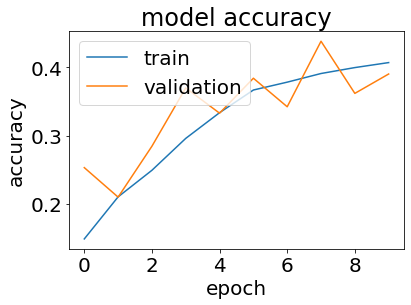

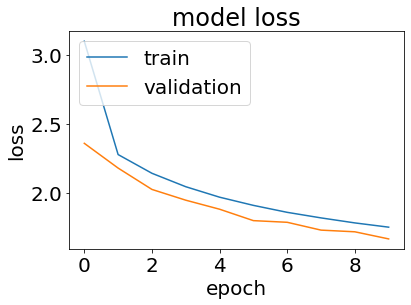

In [60]:
plot_results(transfer_history)

In [61]:
transfer_model.evaluate(x_test_hr, y_test_ohe)

310/310 [==============================] - 2s 7ms/step - loss: 1.7372 - accuracy: 0.3644 - auc: 0.8613


[1.7372111082077026, 0.3643622398376465, 0.8613112568855286]

In [62]:
del x_train_hr, y_train_hr,x_val_hr, y_val_hr,x_test_hr, y_test_hr

In [63]:
x_train, y_train = get_scaled_data(train_df,'activityID')
x_val, y_val = get_scaled_data(train_df,'activityID')
x_test, y_test = get_scaled_data(train_df,'activityID')


In [64]:
y_train_ohe = hot.fit_transform(y_train)
print(hot.categories_)

y_val_ohe = hot.fit_transform(y_val)

y_test_ohe = hot.fit_transform(y_test)

del y_train, y_val, y_test

[array([ 1,  2,  3,  4,  5,  6,  7, 12, 13, 16, 17, 24])]


f. model improvements ideas:

1. adding activations to the layers

2. Adding more complexity to the model (more LSTM layers)

3. Adding regularization to the model to prevent overfitting



g. implementation of improvements:

improvement 1 - adding activations to the layers

In [65]:
improve1 = Sequential()
improve1.add(LSTM(24, input_shape=(x_train.shape[1],x_train.shape[2]), return_sequences=True, activation='tanh'))
improve1.add(Dense(24, activation='relu'))
improve1.add(LSTM(12, return_sequences=False, activation='tanh'))
improve1.add(Dense(12, activation='relu'))
improve1.add(Dense(y_train_ohe.shape[1],activation='softmax'))
improve1.compile( optimizer= 'adam',loss='categorical_crossentropy', metrics=['accuracy'])
improve1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 200, 24)           4704      
_________________________________________________________________
dense_6 (Dense)              (None, 200, 24)           600       
_________________________________________________________________
lstm_4 (LSTM)                (None, 12)                1776      
_________________________________________________________________
dense_7 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_8 (Dense)              (None, 12)                156       
Total params: 7,392
Trainable params: 7,392
Non-trainable params: 0
_________________________________________________________________


In [66]:
path_to_save_model_imp1 = r'drive/My Drive/DeepLearnCourse/ass2/model_best_imp1'+str(num)+'.h5'

imp1_history = improve1.fit(x_train, y_train_ohe, batch_size=128, epochs=10, validation_data=(x_val, y_val_ohe),
                    callbacks=create_callbacks(path=path_to_save_model_imp1))

Epoch 1/10
265/265 [==============================] - 11s 33ms/step - loss: 2.2336 - accuracy: 0.1579 - val_loss: 1.5251 - val_accuracy: 0.4712
Epoch 2/10
265/265 [==============================] - 8s 29ms/step - loss: 1.2768 - accuracy: 0.4899 - val_loss: 0.8268 - val_accuracy: 0.7183
Epoch 3/10
265/265 [==============================] - 7s 28ms/step - loss: 0.8512 - accuracy: 0.6846 - val_loss: 0.5990 - val_accuracy: 0.7963
Epoch 4/10
265/265 [==============================] - 7s 28ms/step - loss: 1.2237 - accuracy: 0.5797 - val_loss: 1.7785 - val_accuracy: 0.3166
Epoch 5/10
265/265 [==============================] - 8s 30ms/step - loss: 1.6188 - accuracy: 0.4183 - val_loss: 1.0937 - val_accuracy: 0.6284
Epoch 6/10
265/265 [==============================] - 8s 28ms/step - loss: 1.0115 - accuracy: 0.6323 - val_loss: 0.7836 - val_accuracy: 0.7459
Epoch 7/10
265/265 [==============================] - 7s 28ms/step - loss: 0.7213 - accuracy: 0.7543 - val_loss: 0.5830 - val_accuracy: 0.794

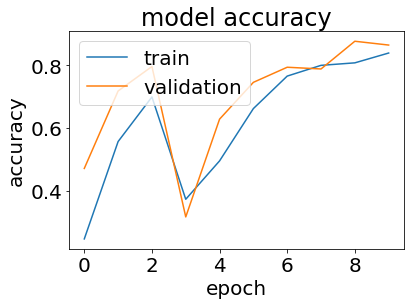

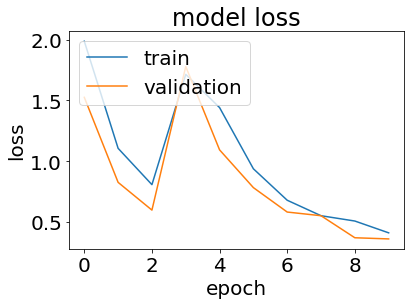

In [67]:
plot_results(imp1_history)

In [68]:
improve1.evaluate(x_test, y_test_ohe)

1058/1058 [==============================] - 9s 9ms/step - loss: 0.3623 - accuracy: 0.8648


[0.3622876703739166, 0.8647642731666565]

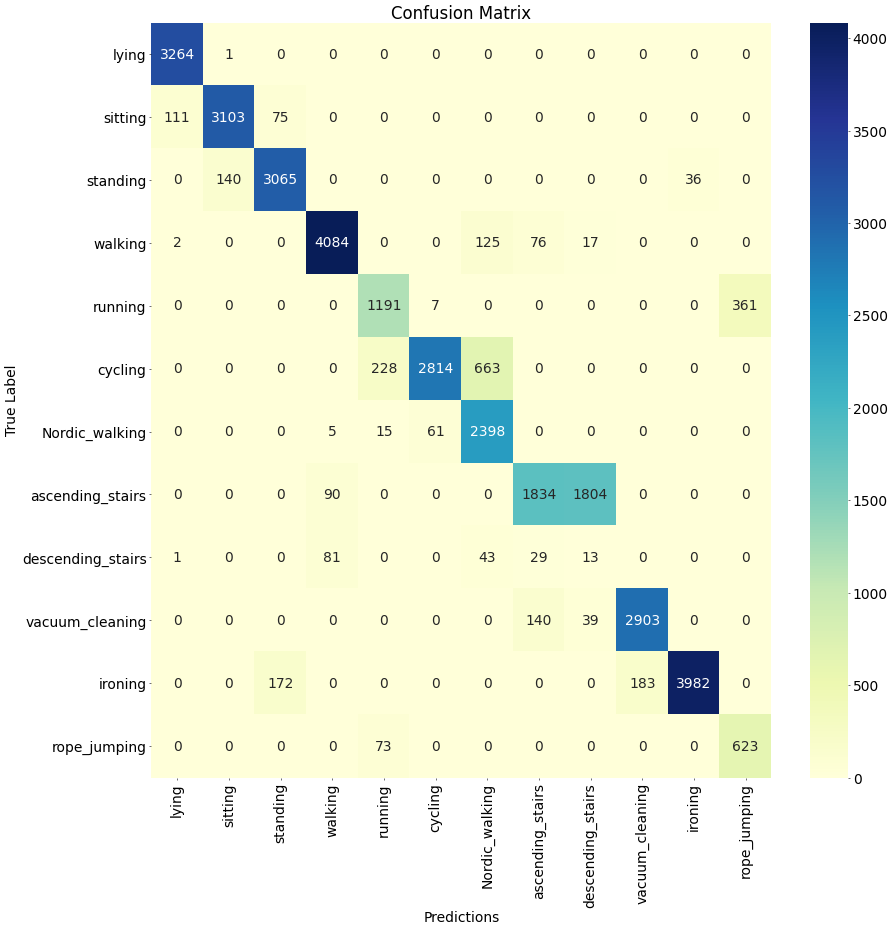

In [69]:
y_test_origin = hot.inverse_transform(y_test_ohe)

preds = improve1.predict(x_test)
ans = []
for array in preds:
  max_index = array.argmax(axis=0)
  a = np.zeros(array.shape[0])
  a[max_index] = 1
  ans.append(a)

ans_origin = hot.inverse_transform(ans)

confusion_matrix_to_model(ans_origin,y_test_origin)

improvement 2 - adding complexity to the layers

In [70]:
improve2 = Sequential()
improve2.add(LSTM(64, input_shape=(x_train.shape[1],x_train.shape[2]), return_sequences=True, activation='tanh'))
improve2.add(Dense(64, activation='relu'))
improve2.add(Dense(64, activation='relu'))
improve2.add(Dropout(0.2))
improve2.add(LSTM(32, return_sequences=False, activation='tanh'))
improve2.add(Dense(32, activation='relu'))
improve2.add(Dense(32, activation='relu'))
improve2.add(Dense(y_train_ohe.shape[1],activation='softmax'))
improve2.compile( optimizer= 'adam',loss='categorical_crossentropy', metrics=['accuracy'])
improve2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 200, 64)           22784     
_________________________________________________________________
dense_9 (Dense)              (None, 200, 64)           4160      
_________________________________________________________________
dense_10 (Dense)             (None, 200, 64)           4160      
_________________________________________________________________
dropout (Dropout)            (None, 200, 64)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_12 (Dense)             (None, 32)               

In [71]:
path_to_save_model_imp2 = r'drive/My Drive/DeepLearnCourse/ass2/model_best_imp2'+str(num)+'.h5'

imp2_history = improve2.fit(x_train, y_train_ohe, batch_size=128, epochs=10, validation_data=(x_val, y_val_ohe),
                    callbacks=create_callbacks(path=path_to_save_model_imp2))

Epoch 1/10
265/265 [==============================] - 12s 36ms/step - loss: 1.7653 - accuracy: 0.3687 - val_loss: 0.6400 - val_accuracy: 0.7200
Epoch 2/10
265/265 [==============================] - 8s 30ms/step - loss: 0.6823 - accuracy: 0.7109 - val_loss: 0.6026 - val_accuracy: 0.7550
Epoch 3/10
265/265 [==============================] - 8s 32ms/step - loss: 0.4752 - accuracy: 0.8057 - val_loss: 0.3937 - val_accuracy: 0.8413
Epoch 4/10
265/265 [==============================] - 8s 31ms/step - loss: 0.3981 - accuracy: 0.8380 - val_loss: 0.3700 - val_accuracy: 0.8490
Epoch 5/10
265/265 [==============================] - 8s 31ms/step - loss: 0.3399 - accuracy: 0.8610 - val_loss: 0.2232 - val_accuracy: 0.9150
Epoch 6/10
265/265 [==============================] - 8s 32ms/step - loss: 0.2492 - accuracy: 0.8994 - val_loss: 0.1921 - val_accuracy: 0.9191
Epoch 7/10
265/265 [==============================] - 8s 32ms/step - loss: 0.2826 - accuracy: 0.8895 - val_loss: 0.1750 - val_accuracy: 0.925

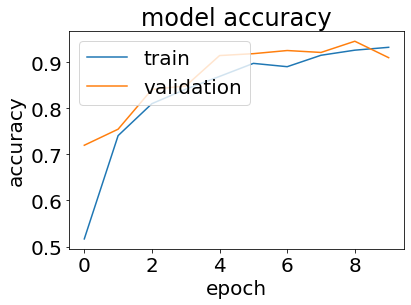

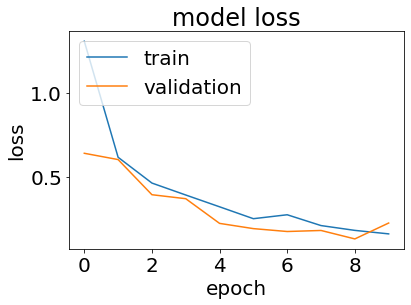

In [72]:
plot_results(imp2_history)

In [73]:
improve2.evaluate(x_test, y_test_ohe)

1058/1058 [==============================] - 10s 10ms/step - loss: 0.2253 - accuracy: 0.9104


[0.22531314194202423, 0.9103745818138123]

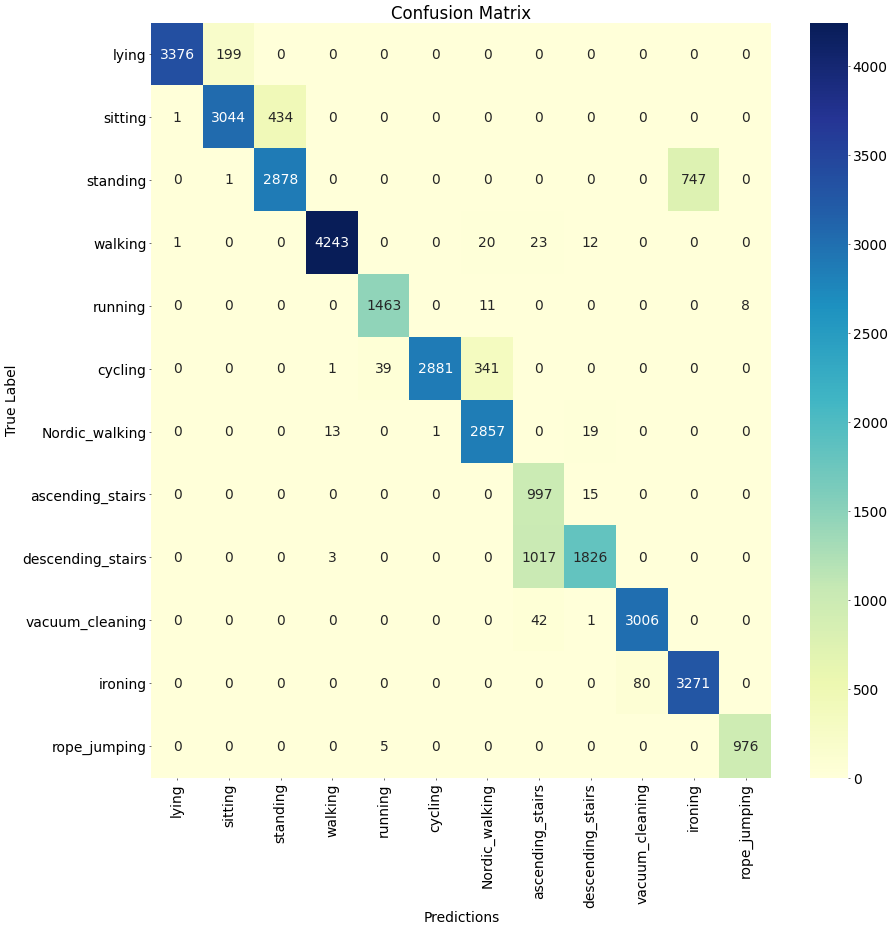

In [74]:
y_test_origin = hot.inverse_transform(y_test_ohe)

preds = improve2.predict(x_test)
ans = []
for array in preds:
  max_index = array.argmax(axis=0)
  a = np.zeros(array.shape[0])
  a[max_index] = 1
  ans.append(a)

ans_origin = hot.inverse_transform(ans)

confusion_matrix_to_model(ans_origin,y_test_origin)